In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.image

from tensorflow import keras
from tensorflow.keras import layers

In [9]:
assert tf.__version__ >= '2.3.0'

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

In [5]:
os.listdir(data_dir)

['dandelion', 'sunflowers', 'tulips', 'roses', 'LICENSE.txt', 'daisy']

In [41]:
class_names = ['dandelion', 'sunflowers', 'tulips', 'roses', 'daisy']

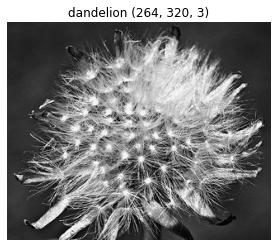

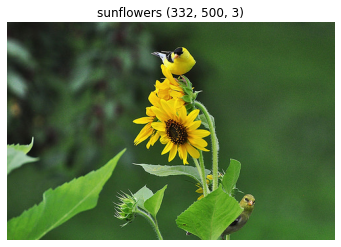

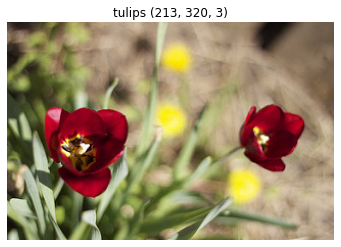

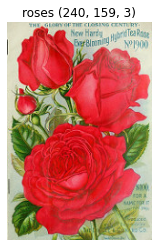

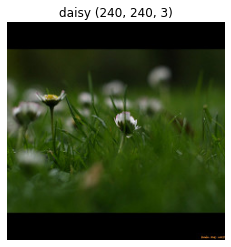

In [42]:
for flower in class_names:
    fname = os.listdir(os.path.join(data_dir, flower))[0]
    image = matplotlib.image.imread(os.path.join(data_dir, flower, fname))
    plt.imshow(image)
    plt.title(flower + ' {}'.format(image.shape))
    plt.axis('off')
    plt.show()

We can use one of the standard data loading libraries of Keras to load the JPG images as suitable inputs for the Keras models.

NB this needs tf >=2.3.0 !

Our images have different sizes, so we need to provide the data loader an image size to which it will resize

Also, we want to normalize the range [0,255] to [0,1]

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [52]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                         rescale=1./255)
train_ds = tf.keras.preprocessing.image.DirectoryIterator(directory=data_dir,
                                                    image_data_generator=datagen,
                                                    target_size=(img_height, img_width),
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    classes = class_names,
                                                    seed=123)

val_ds = tf.keras.preprocessing.image.DirectoryIterator(directory=data_dir,
                                                    image_data_generator=datagen,
                                                    target_size=(img_height, img_width),
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    classes = class_names,
                                                    seed=123)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [81]:
# For tf >= 2.3.0: we can use the simpler data loader
# train_ds = keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2, # How much do we reserve for validation?
#   subset="training", # Means this results in the train set
#   seed=123,
#   image_size=(img_height, img_width), # Resize to this scale
#   batch_size=batch_size)

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

Note that `train_ds` is an iterator over batches of training data and labels, we can also iterate to inspect:

In [63]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(image_batch.dtype)
    break

(32, 180, 180, 3)
(32, 5)
float32


We plot a few images from the first batch that the data loader provides to us, so these are resized:

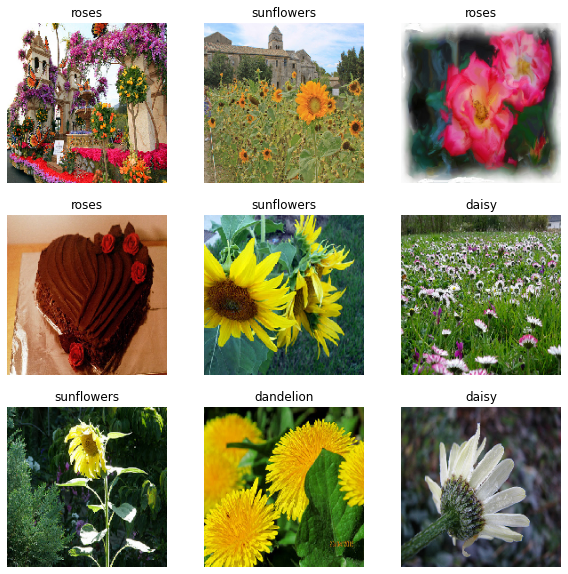

In [79]:
plt.figure(figsize=(10, 10))
images, labels = train_ds.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

By default, the data loader will load the images again disk in each training epoch. In this case, the dataset is small enough to fit into memory, so we want to cache it:

In [82]:
# with the newer data loader
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

The RGB channel values are currently in the range of [0,255] but it is better if our input is small, e.g. between 0 and 1. We will use the rescaling layer to divide our values by 255.

In [85]:
num_classes = len(class_names)

inputs =  keras.layers.Input(shape=(img_height, img_width, 3))
# x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes)(x)

In [86]:
model = keras.Model(inputs=inputs, outputs=outputs, name="flowers_model")

In [87]:
model.summary()

Model: "flowers_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)      

In [92]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Now train the model

In [93]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 89s 972ms/step - loss: 1.2890 - accuracy: 0.4512 - val_loss: 1.0754 - val_accuracy: 0.5923
Epoch 2/10
92/92 [==============================] - 89s 967ms/step - loss: 0.9993 - accuracy: 0.5985 - val_loss: 1.0275 - val_accuracy: 0.6156
Epoch 3/10
92/92 [==============================] - 90s 976ms/step - loss: 0.8489 - accuracy: 0.6774 - val_loss: 1.0450 - val_accuracy: 0.6170
Epoch 4/10
92/92 [==============================] - 90s 974ms/step - loss: 0.6845 - accuracy: 0.7445 - val_loss: 0.9681 - val_accuracy: 0.6320
Epoch 5/10
92/92 [==============================] - 89s 970ms/step - loss: 0.4920 - accuracy: 0.8183 - val_loss: 0.9956 - val_accuracy: 0.6402
Epoch 6/10
92/92 [==============================] - 89s 971ms/step - loss: 0.3072 - accuracy: 0.8887 - val_loss: 1.0352 - val_accuracy: 0.6484
Epoch 7/10
92/92 [==============================] - 101s 1s/step - loss: 0.1917 - accuracy: 0.9384 - val_loss: 1.1693 - val_accuracy: 0.6471
E

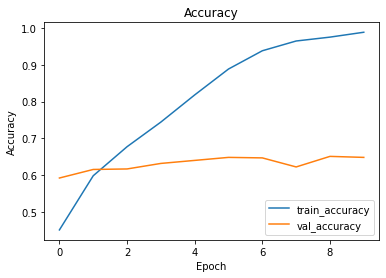

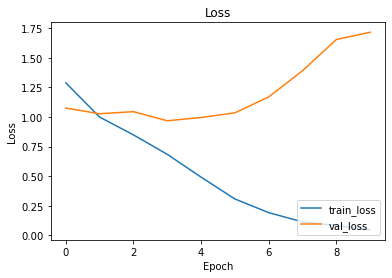

In [95]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title('Loss')
plt.show()

overfitting, so introduce dropout:

In [96]:
inputs =  keras.layers.Input(shape=(img_height, img_width, 3))
# x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes)(x)

In [97]:
model_dropout = keras.Model(inputs=inputs, outputs=outputs, name="flowers_model_dropout")

In [98]:
model_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [99]:
epochs=10
history_dropout = model_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 96s 1s/step - loss: 1.4050 - accuracy: 0.4199 - val_loss: 1.2243 - val_accuracy: 0.4829
Epoch 2/10
92/92 [==============================] - 97s 1s/step - loss: 1.0558 - accuracy: 0.5747 - val_loss: 1.0682 - val_accuracy: 0.5882
Epoch 3/10
92/92 [==============================] - 89s 970ms/step - loss: 0.8835 - accuracy: 0.6621 - val_loss: 0.9622 - val_accuracy: 0.6279
Epoch 4/10
92/92 [==============================] - 92s 1s/step - loss: 0.7313 - accuracy: 0.7159 - val_loss: 0.9391 - val_accuracy: 0.6443
Epoch 5/10
92/92 [==============================] - 108s 1s/step - loss: 0.5583 - accuracy: 0.7907 - val_loss: 0.9740 - val_accuracy: 0.6334
Epoch 6/10
92/92 [==============================] - 139s 2s/step - loss: 0.4088 - accuracy: 0.8499 - val_loss: 1.0274 - val_accuracy: 0.6265
Epoch 7/10
92/92 [==============================] - 128s 1s/step - loss: 0.2390 - accuracy: 0.9200 - val_loss: 1.2177 - val_accuracy: 0.6265
Epoch 8/10
92/

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title('Loss')
plt.show()